<a href="https://www.kaggle.com/code/dalloliogm/autogluon-approach-to-fertiz?scriptVersionId=243022158" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Autogluon approach

Autogluon is an autoML tool from Amazon. It performed well in previous playground competitions. Let's try it out.

In [1]:
# Go to Add-ons > Install Dependencies to install this into the environment
!pip install -q autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.7/222.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.4/382.4 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 14.0 MB/s eta 0:0

## Parameters

In [2]:
import os
import pandas as pd
import polars as pl
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

def is_interactive_session():
    return os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive'

is_interactive_session()

config = {
    "autogluon_time": 3600,
    "autogluon_presets": "best_quality",
    #"reduce_features": 0, # Set to >0 to use only the first n features
    "tail_rows": 0 # Set to >0 to use only the last n rows in the file
    
}

if is_interactive_session():
    print("Interactive session")
    config["autogluon_time"] = 100
    #config["reduce_features"] = 200
    config["autogluon_presets"] = "medium_quality"
    config["tail_rows"] = 2000
    print(config)
else:
    print("running as job")
    print(config)

running as job
{'autogluon_time': 3600, 'autogluon_presets': 'best_quality', 'tail_rows': 0}


## Read data

In [3]:
import pandas as pd

train = pd.read_csv('/kaggle/input/playground-series-s5e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e6/test.csv')


In [4]:
train.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [5]:
from autogluon.tabular import TabularPredictor


## Some Feature Engineering

### Nutrient Ratios

Fertilizers are often chosen based on nutrient balance, not just raw amounts.



In [6]:
train['N_P_ratio'] = train['Nitrogen'] / (train['Phosphorous'] + 1)
train['N_K_ratio'] = train['Nitrogen'] / (train['Potassium'] + 1)
train['P_K_ratio'] = train['Phosphorous'] / (train['Potassium'] + 1)
test['N_P_ratio'] = test['Nitrogen'] / (test['Phosphorous'] + 1)
test['N_K_ratio'] = test['Nitrogen'] / (test['Potassium'] + 1)
test['P_K_ratio'] = test['Phosphorous'] / (test['Potassium'] + 1)


### Weather Soil Interactions

In [7]:
train['Temp_Humidity'] = train['Temparature'] * train['Humidity']
train['Soil_Crop'] = train['Soil Type'] + '_' + train['Crop Type']
test['Temp_Humidity'] = test['Temparature'] * test['Humidity']
test['Soil_Crop'] = test['Soil Type'] + '_' + test['Crop Type']


### Polynomial binning

In [8]:
# Bin temparature
train['Temp_bin'] = pd.cut(train['Temparature'], bins=[0, 20, 30, 40, 60], labels=['Low', 'Med', 'High', 'Very High'])
# Combine with crop
train['Crop_Temp_bin'] = train['Crop Type'] + '_' + train['Temp_bin'].astype(str)


test['Temp_bin'] = pd.cut(test['Temparature'], bins=[0, 20, 30, 40, 60], labels=['Low', 'Med', 'High', 'Very High'])
# Combine with crop
test['Crop_Temp_bin'] = test['Crop Type'] + '_' + test['Temp_bin'].astype(str)


## Train Predictor

Autogluon will try several models and parameters. To trigger the training, just call .fit().

In [9]:
label = 'Fertilizer Name'
predictor = TabularPredictor(label="Fertilizer Name", 
                            eval_metric="log_loss").\
                fit(
                            train,
                            presets=config["autogluon_presets"],
                            time_limit=config["autogluon_time"])


No path specified. Models will be saved in: "AutogluonModels/ag-20250601_080045"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       28.18 GB / 31.35 GB (89.9%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be 

In [10]:
probs = predictor.predict_proba(test)  
top3_preds = probs.apply(lambda row: row.nlargest(3).index.tolist(), axis=1)


In [11]:
# from sklearn.metrics import label_ranking_average_precision_score
# import numpy as np

# # Ground truth as binary indicator matrix
# y_true = pd.get_dummies(test['Fertilizer Name']).values
# y_score = probs[test.columns[1:]]  # drop 'id'

# map3 = label_ranking_average_precision_score(y_true, y_score)
# print(f'MAP@3: {map3:.4f}')


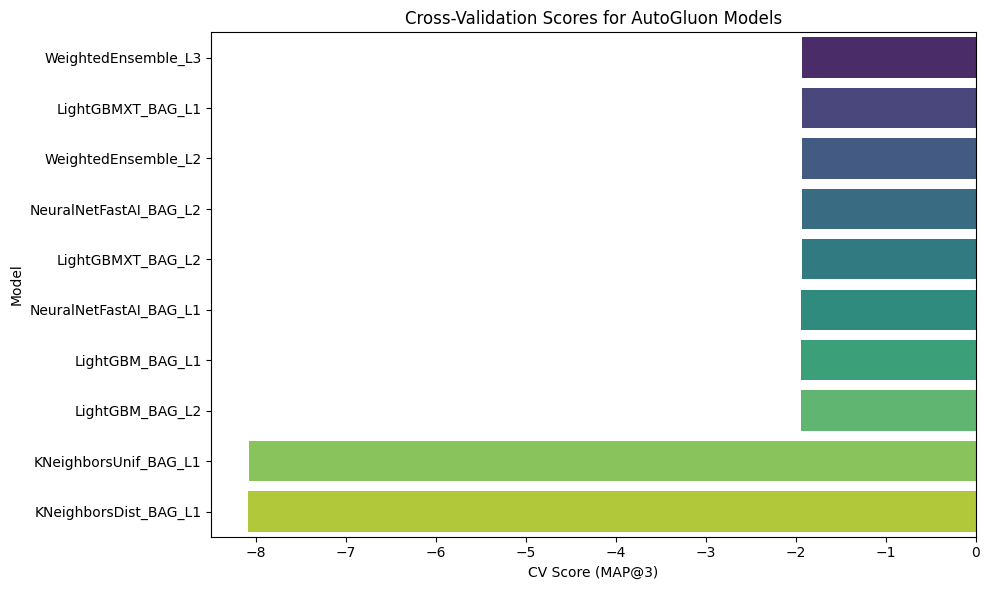

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get leaderboard with scores
lb = predictor.leaderboard(silent=True)

# Filter only models with valid CV scores
lb = lb[~lb['score_val'].isna()]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=lb, x='score_val', y='model', palette='viridis')
plt.xlabel('CV Score (MAP@3)')
plt.ylabel('Model')
plt.title('Cross-Validation Scores for AutoGluon Models')
plt.tight_layout()
plt.show()


In [13]:
# def mapk(y_true, y_pred, k=3):
#     def apk(actual, predicted, k):
#         predicted = predicted[:k]
#         score = 0.0
#         num_hits = 0.0
#         for i, p in enumerate(predicted):
#             if p == actual and p not in predicted[:i]:
#                 num_hits += 1.0
#                 score += num_hits / (i + 1.0)
#                 break  # Only the first correct label counts
#         return score

#     return np.mean([apk(a, p, k) for a, p in zip(y_true, y_pred)])

# # Use it:
# true_labels = val["Fertilizer Name"].values
# map3_score = mapk(true_labels, top3_preds, k=3)
# print(f"Strict MAP@3: {map3_score:.4f}")


In [14]:
probs = predictor.predict_proba(test)
top3 = probs.apply(lambda x: ' '.join(x.nlargest(3).index), axis=1)
submission = pd.DataFrame({'id': test['id'], 'Fertilizer Name': top3})
submission.to_csv('submission.csv', index=False)
